In [26]:
import pandas as pd 

df_scaled = pd.read_csv('../data/scaled_data.csv')
df_not_scaled = pd.read_csv('../data/not_scaled_data.csv')

In [27]:
df_not_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4735 entries, 0 to 4734
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               4735 non-null   int64  
 1   homeType              4735 non-null   int64  
 2   yearBuilt             4735 non-null   int64  
 3   lotAreaValue          4735 non-null   float64
 4   livingAreaValue       4735 non-null   float64
 5   bedrooms              4735 non-null   int64  
 6   bathrooms             4735 non-null   float64
 7   stories               4735 non-null   float64
 8   hasFireplace          4735 non-null   int64  
 9   taxAssessedValue      4735 non-null   float64
 10  rentZestimate         4735 non-null   float64
 11  price                 4735 non-null   int64  
 12  parkingCapacity       4735 non-null   int64  
 13  hasCooling            4735 non-null   int64  
 14  hasHeating            4735 non-null   int64  
 15  hasFireplace.1       

In [28]:
from sklearn import metrics
import numpy as np

def calc_median_absolute_percentage_error(y_true, y_pred):
    return np.median(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y_pred, y_test):
    r2 = metrics.r2_score(y_test, y_pred)
    smse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    mean_ae = metrics.mean_absolute_error(y_test, y_pred)
    mean_ape = metrics.mean_absolute_percentage_error(y_test, y_pred)
    median_ae = metrics.median_absolute_error(y_test, y_pred)
    median_ape = calc_median_absolute_percentage_error(y_test, y_pred)
    return [r2, smse, mean_ae, mean_ape, median_ae, median_ape]
    
def within_x_percent(y_pred, y_test, x):
    return np.sum(np.abs((y_pred - y_test)/y_test) < x) / len(y_test) * 100

def show_metrics(y_pred, y_test, target_scaler = None, logarithm = False):        
    metrics_df = pd.DataFrame(columns=['Target', 'R2', 'Root Mean Squared Error', 'Mean Absolute Error',
                                            'Mean Absolute Percentage Error', 'Median Absolute Error', 'Median Absolute Percentage Error'])
    
    metrics_df.loc[0] = ['Target is scaled'] + calculate_metrics(y_pred, y_test)
    
    if target_scaler:
        y_pred = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        y_test = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
        metrics_df.loc[1] = ['Scaled Target is inversed to real value'] + calculate_metrics(y_pred, y_test)

    
    if logarithm:
        y_pred = np.power(10, y_pred)
        y_test = np.power(10, y_test)
        metrics_df.loc[2] = ['Target -> 10 ^ Target'] + calculate_metrics(y_pred, y_test)
    
    dist_df = pd.DataFrame({"within 5%": [within_x_percent(y_pred, y_test, 0.05)],
                    "within 10%": [within_x_percent(y_pred, y_test, 0.10)],
                    "within 20%": [within_x_percent(y_pred, y_test, 0.20)],
                    "within 50%": [within_x_percent(y_pred, y_test, 0.50)],
                    "median absolute percentage error": [calc_median_absolute_percentage_error(y_test, y_pred)]}, index=['Percentage'])
        
    display(metrics_df)
    display(dist_df)

In [29]:
from abc import ABC, abstractmethod
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

class RegressionModel(ABC):
    def __init__(self, features, target, params, scale=True, logarithm=False):
        if scale:
            self.feature_scaler = StandardScaler()
            self.target_scaler = StandardScaler()
            self.features = self.feature_scaler.fit_transform(features)
            self.target = self.target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()
        else:
            self.feature_scaler = None
            self.target_scaler = None
            self.features = features
            self.target = target.values.flatten()
            
        self.logarithm = logarithm
        
        X_train, X_test, y_train, y_test = train_test_split(self.features, self.target, test_size=0.1, random_state=42)
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

        self.model = self.create_model(params)
        self.search_params = self.set_search_params()
        self.model.fit(X_train, y_train)
        self.y_pred = self.model.predict(X_test)
        #show_metrics(self.model.predict(X_train), y_train, self.target_scaler, logarithm)
        
    @abstractmethod
    def create_model(self, params):
        pass
    
    @abstractmethod
    def set_search_params(self):
        pass
    
    def predict(self, features):
        if self.feature_scaler:
           features = self.feature_scaler.transform(features)
        return self.model.predict(features)
    
    def grid_search(self):
        grid_search = GridSearchCV(self.model, self.search_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=2)
        grid_search.fit(self.X_train, self.y_train)
        best_model = grid_search.best_estimator_
        test_score = best_model.score(self.X_test, self.y_test)
        self.model = best_model
        self.y_pred = self.model.predict(self.X_test)
        return best_model, test_score
    
    def show_metrics(self):
        show_metrics(self.y_pred, self.y_test, self.target_scaler, self.logarithm)
    
    def draw_predictions(self, log=False):
        if self.target_scaler:
            y_pred = self.target_scaler.inverse_transform(self.y_pred.reshape(-1, 1)).ravel()
            y_test = self.target_scaler.inverse_transform(self.y_test.reshape(-1, 1)).ravel()
        else:
            y_pred = self.y_pred
            y_test = self.y_test
        
        if log:
            y_pred = np.power(10, y_pred)
            y_test = np.power(10, y_test)
        
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_test, y=y_pred, color='blue', label='Predicted vs Actual')
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Ideal Fit')
        plt.title('Actual vs Predicted Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.show()
        
    def get_feature_importance(self):
        perm_importance = permutation_importance(self.model, self.X_train, self.y_train, n_repeats=10, random_state=42)
        feature_importances_df = pd.DataFrame({
                'Feature': self.features.columns,
                'Importance': perm_importance.importances_mean
            })
        display(feature_importances_df.sort_values(by='Importance', ascending=False))
    
                        

In [30]:
from sklearn.svm import SVR
class SVRModel(RegressionModel):
    def create_model(self, params):
        return SVR(**params)
    def set_search_params(self):
        return {
            'C': [0.1, 1, 10, 100, 1000],
            'epsilon': [0.01, 0.1, 0.2, 0.5, 1],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        }

In [31]:
df_not_scaled.columns

Index(['zipcode', 'homeType', 'yearBuilt', 'lotAreaValue', 'livingAreaValue',
       'bedrooms', 'bathrooms', 'stories', 'hasFireplace', 'taxAssessedValue',
       'rentZestimate', 'price', 'parkingCapacity', 'hasCooling', 'hasHeating',
       'hasFireplace.1', 'hasPrivatePool', 'hasSpa', 'hasView',
       'log_lotAreaValue', 'log_livingAreaValue', 'log_price',
       'log_taxAssessedValue'],
      dtype='object')

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target is scaled,0.885158,0.355188,0.246349,1.520097,0.170384,28.299994
1,Scaled Target is inversed to real value,0.885158,0.097201,0.067416,0.011173,0.046628,0.763961
2,Target -> 10 ^ Target,0.865621,477064.775836,228457.574731,0.160508,112539.137591,10.385817


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,24.050633,48.312236,74.261603,95.991561,10.385817


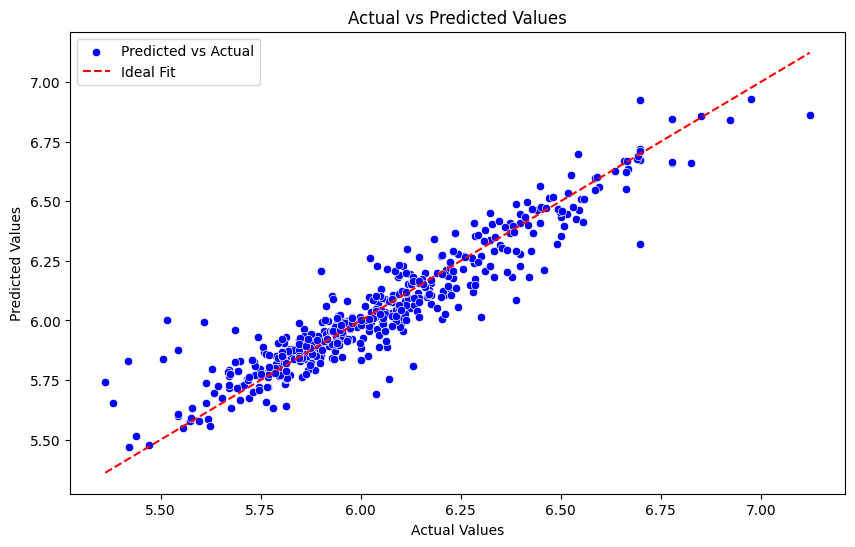

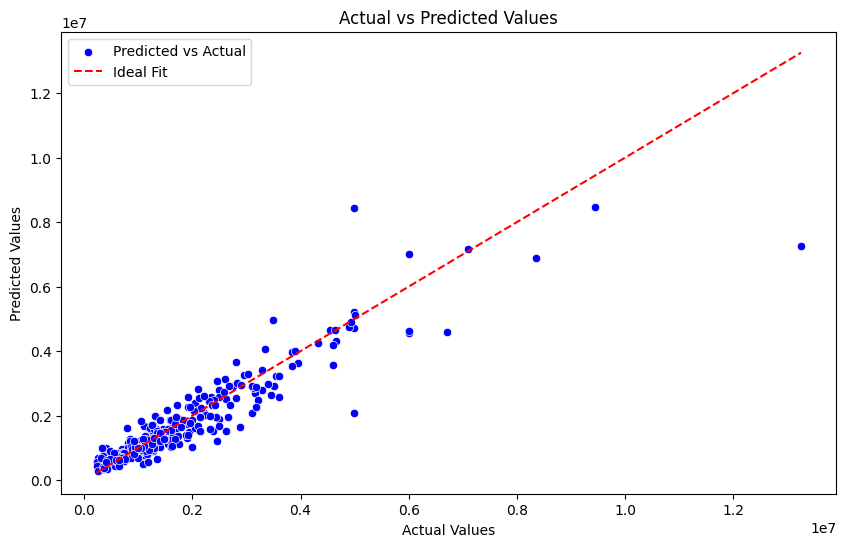

In [32]:
#features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
features = df_not_scaled[["log_taxAssessedValue", "log_livingAreaValue", "log_lotAreaValue", "hasFireplace", "rentZestimate", 
                          "bedrooms", "bathrooms", "lotAreaValue", "livingAreaValue", "parkingCapacity", 'zipcode', 'hasView',
                          'hasCooling', ]]
target = df_not_scaled['log_price']
model = SVRModel(features, target, params={'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}, scale=True, logarithm=True)
model.show_metrics()
model.draw_predictions()
model.draw_predictions(log=True)

In [184]:
model.grid_search()

KeyboardInterrupt: 

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target is scaled,-0.046903,1.563038e+06,767937.587931,0.582394,434119.408155,42.092473


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,7.006369,14.012739,26.433121,57.961783,42.092473


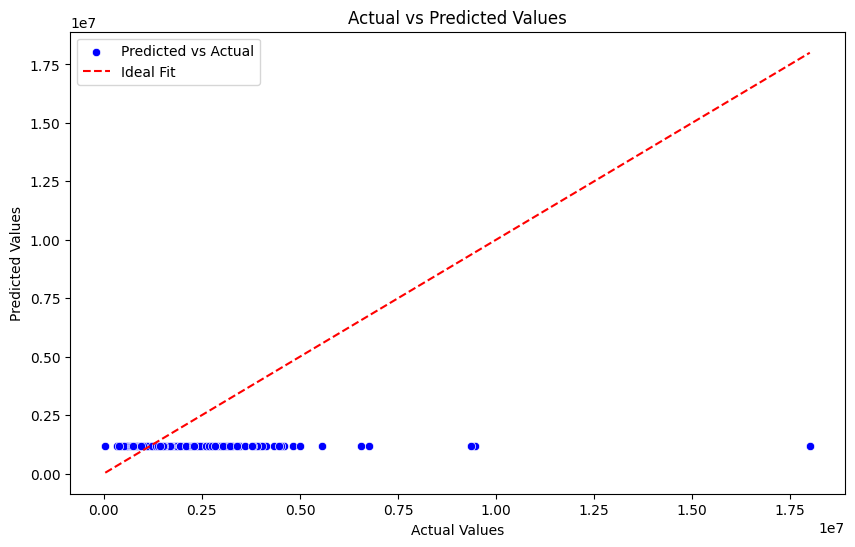

In [8]:
#features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
features = df_not_scaled[["log_taxAssessedValue", "log_livingAreaValue", "log_lotAreaValue", "hasFireplace", "rentZestimate", 
                          "bedrooms", "bathrooms", "lotAreaValue", "livingAreaValue", "parkingCapacity"]]

target = df_not_scaled['price']
model = SVRModel(features, target, params={'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}, scale=True, logarithm=False)
model.show_metrics()
model.draw_predictions()

In [91]:
model.grid_search()

GridSearchCV(cv=5, estimator=SVR(C=1000, epsilon=0.01), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'epsilon': [0.01, 0.1, 0.2, 0.5, 1],
                         'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]},
             scoring='neg_mean_absolute_error')


(SVR(C=1000, epsilon=0.01, gamma='auto'), 0.0019784610496236255)

In [ ]:
model.grid_search()

In [193]:
from sklearn.linear_model import LinearRegression

class LinearRegressionModel(RegressionModel):
    def create_model(self, params):
        return LinearRegression()
    def set_search_params(self):
        return {}
    

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target is scaled,0.897165,0.294109,0.185300,1.130412,0.103120,24.877981
1,Scaled Target is inversed to real value,0.897165,417333.067853,262935.547035,0.214227,146324.185899,12.945208


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,18.776371,39.451477,65.400844,93.248945,12.945208


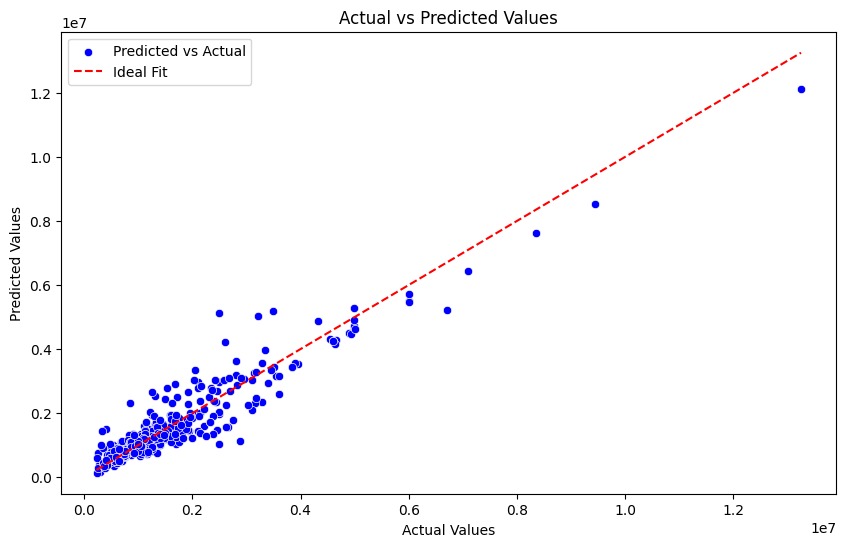

In [200]:
#features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
features = df_not_scaled[["livingAreaValue", "rentZestimate", 
                           "lotAreaValue", "livingAreaValue", "parkingCapacity", 'zipcode', 'yearBuilt', 'bedrooms']]
target = df_not_scaled['price']
model = LinearRegressionModel(features, target, params={}, scale=True, logarithm=False)
model.show_metrics()
model.draw_predictions()

In [204]:
from sklearn.neighbors import KNeighborsRegressor

class KNeighborsRegressorModel(RegressionModel):
    def create_model(self, params):
        return KNeighborsRegressor(**params)
    def set_search_params(self):
        return {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }

In [182]:
model.grid_search()

(KNeighborsRegressor(n_neighbors=7, weights='distance'), 0.8553657203636134)

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target is scaled,0.801302,0.467204,0.348208,1.675733,0.272782,38.720327
1,Scaled Target is inversed to real value,0.801302,0.127856,0.095291,0.015800,0.074650,1.202075
2,Target -> 10 ^ Target,0.859612,487615.075998,301618.528463,0.225625,174142.860588,17.058125


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,17.721519,33.544304,57.172996,92.194093,17.058125


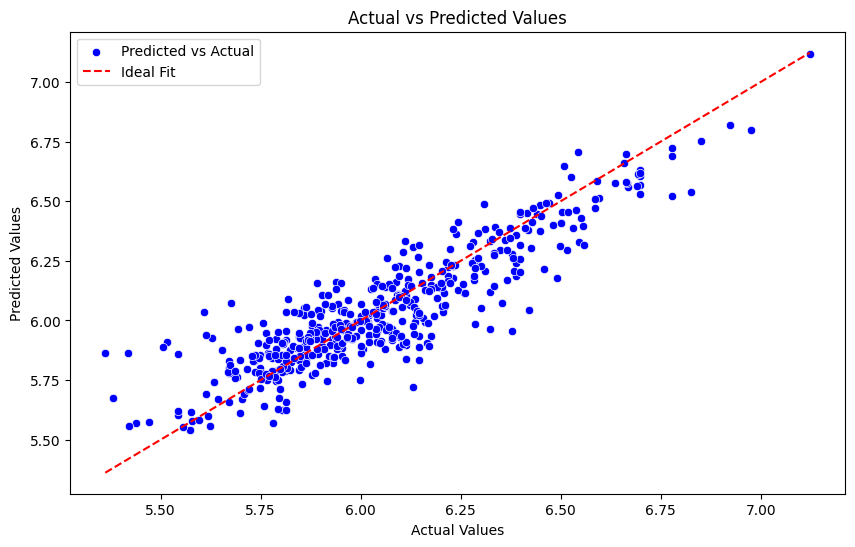

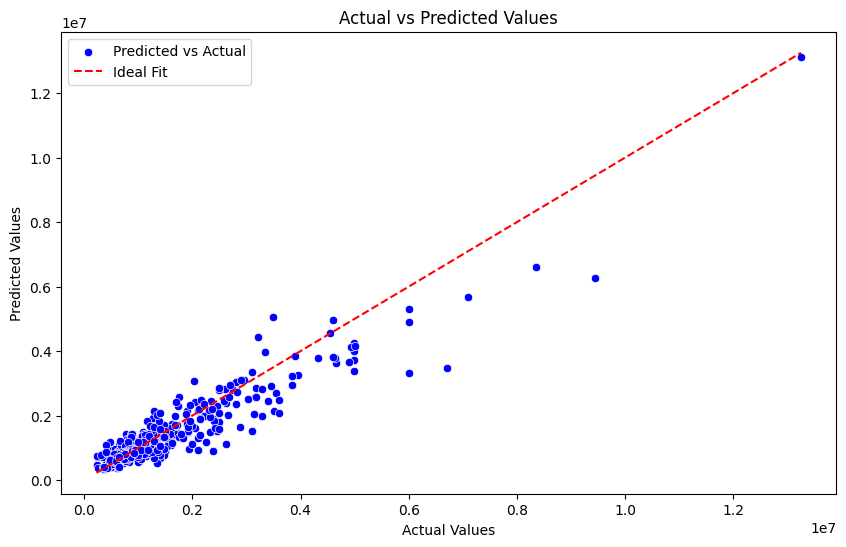

In [205]:
features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
target = df_not_scaled['log_price']
model = KNeighborsRegressorModel(features, target, params={'n_neighbors': 5, 'weights': 'distance'}, scale=True, logarithm=True)
model.show_metrics()
model.draw_predictions()
model.draw_predictions(log=True)

In [206]:
from sklearn.tree import DecisionTreeRegressor

class DecisionTreeRegressorModel(RegressionModel):
    def create_model(self, params):
        return DecisionTreeRegressor(**params)
    def set_search_params(self):
        return {
            'max_depth': [3, 5, 7, 9],
            'min_samples_split': [2, 4, 8],
        }

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target is scaled,0.569233,0.601947,0.208944,1.186603,0.095135,23.381046
1,Scaled Target is inversed to real value,0.569233,854148.471256,296485.861043,0.213398,134994.241138,13.568513


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,24.894515,39.240506,65.822785,92.616034,13.568513


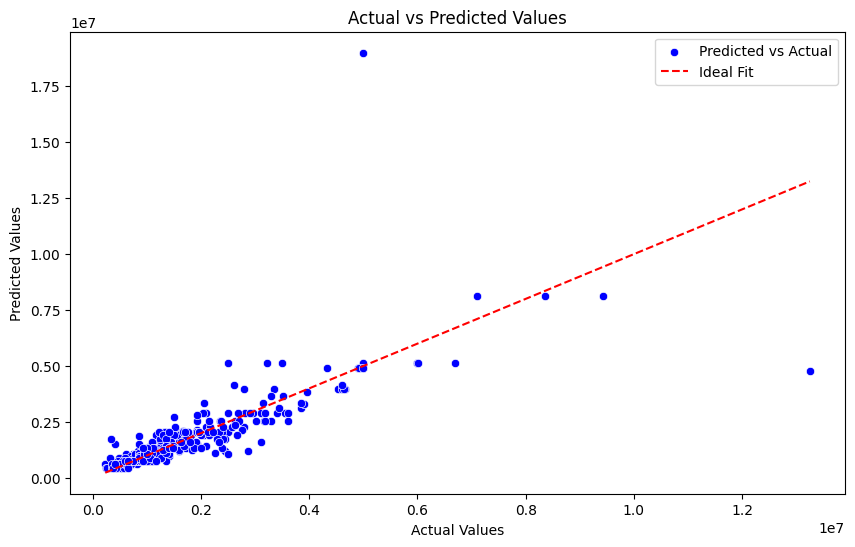

In [212]:
features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])
#features = df_not_scaled[["livingAreaValue", "rentZestimate", 
#                           "lotAreaValue", "livingAreaValue", "parkingCapacity", 'zipcode', 'yearBuilt', 'bedrooms']]

target = df_not_scaled['price']
model = DecisionTreeRegressorModel(features, target, params={'max_depth': 7, 'min_samples_split': 4}, scale=True, logarithm=False)
model.show_metrics()
model.draw_predictions()


In [187]:
model.grid_search()

(DecisionTreeRegressor(max_depth=7, min_samples_split=4), 0.6933435834222461)

,Target,R2,Root Mean Squared Error,Mean Absolute Error,Mean Absolute Percentage Error,Median Absolute Error,Median Absolute Percentage Error
0,Target is scaled,0.842180,0.416380,0.286857,1.623238,0.203355,30.615517
1,Scaled Target is inversed to real value,0.842180,0.113947,0.078502,0.013008,0.055650,0.909094
2,Target -> 10 ^ Target,0.849125,505498.665612,268727.759499,0.195482,133090.639141,12.818230


,within 5%,within 10%,within 20%,within 50%,median absolute percentage error
Percentage,18.35443,39.662447,69.409283,93.459916,12.81823


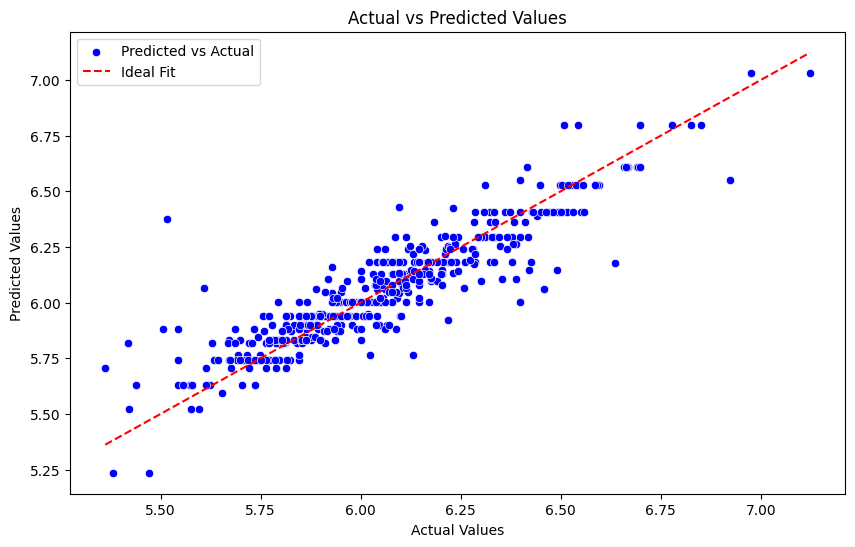

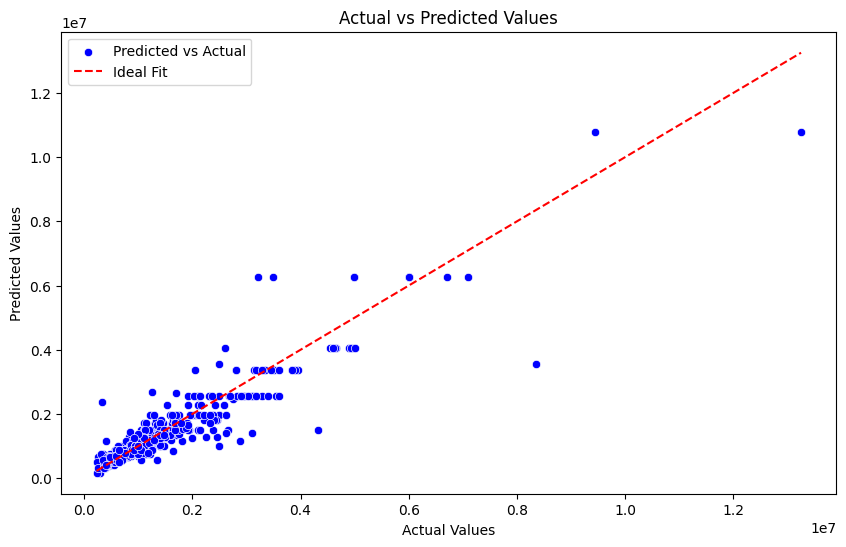

In [213]:
features = df_not_scaled.drop(columns=['price', 'log_taxAssessedValue', 'log_price', 'taxAssessedValue'])

target = df_not_scaled['log_price']
model = DecisionTreeRegressorModel(features, target, params={'max_depth': 7, 'min_samples_split': 4}, scale=True, logarithm=True)
model.show_metrics()
model.draw_predictions()
model.draw_predictions(log=True)

In [159]:
import statsmodels.api as sm
 

features = df_not_scaled.drop(columns=['price', 'log_price'])
print(features.columns)
target = df_not_scaled['price']
st = StandardScaler()
target = st.fit_transform(target.values.reshape(-1, 1))
features = st.fit_transform(features.values)
features = sm.add_constant(features)
ols_model = sm.OLS(target, features).fit()
ols_model.summary()





Index(['zipcode', 'homeType', 'yearBuilt', 'lotAreaValue', 'livingAreaValue',
       'bedrooms', 'bathrooms', 'stories', 'hasFireplace', 'taxAssessedValue',
       'rentZestimate', 'parkingCapacity', 'hasCooling', 'hasHeating',
       'hasFireplace.1', 'hasPrivatePool', 'hasSpa', 'hasView',
       'log_lotAreaValue', 'log_livingAreaValue', 'log_taxAssessedValue'],
      dtype='object')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.858
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     1356.
Date:                Fri, 14 Jun 2024   Prob (F-statistic):               0.00
Time:                        23:40:05   Log-Likelihood:                -2097.6
No. Observations:                4735   AIC:                             4239.
Df Residuals:                    4713   BIC:                             4381.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         3.4e-16      0.005   6.19e-14      1.000      -0.011       0.011
x1            -0.0459      0.006     -7.176      0.000      -0.058      -0.033
x2            -0.0300      0.007     -4.250      0.000      -0.044      -0.016
x3            -0.0304      0.007     -4.469      0.000      -0.044      -0.017
x4            -0.0102      0.009     -1.110      0.267      -0.028       0.008
x5             0.0783      0.019      4.222      0.000       0.042       0.115
x6             0.0260      0.010      2.591      0.010       0.006       0.046
x7             0.0103      0.012      0.855      0.393      -0.013       0.034
x8             0.0044      0.007      0.676      0.499      -0.008       0.017
x9             0.0527      0.018      2.850      0.004       0.016       0.089
x10            0.1512      0.011     14.324      0.000       0.131       0.172
x11            0.7483      0.011     69.338      0.000       0.727       0.769
x12            0.0303      0.007      4.623      0.000       0.017       0.043
x13            0.0227      0.007      3.401      0.001       0.010       0.036
x14            0.0120      0.006      2.015      0.044       0.000       0.024
x15           -0.0292      0.019     -1.570      0.116      -0.066       0.007
x16            0.0149      0.006      2.361      0.018       0.003       0.027
x17            0.0065      0.006      1.059      0.290      -0.006       0.018
x18           -0.0167      0.007     -2.509      0.012      -0.030      -0.004
x19           -0.0003      0.010     -0.029      0.977      -0.021       0.020
x20           -0.0645      0.016     -4.135      0.000      -0.095      -0.034
x21            0.0025      0.009      0.285      0.776      -0.015       0.019
==============================================================================
Omnibus:                     6415.654   Durbin-Watson:                   1.679
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12282436.898
Skew:                           6.870   Prob(JB):                         0.00
Kurtosis:                     252.131   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""